In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optims
import numpy as np
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Wed May 20 10:07:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
probability = [1.00000000e+00, 
 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
 1.00000000e+00, 1.00000000e+00, 6.27850450e-57, 7.88167347e-56, 7.89730869e-48,
 3.93009432e-53, 3.42023763e-61, 1.33541163e-27, 3.66994210e-53]
probability = np.asarray(probability)
prob = np.zeros((probability.shape[0], 2))

prob[:,0] = probability
prob[:,1] = 1 - probability 


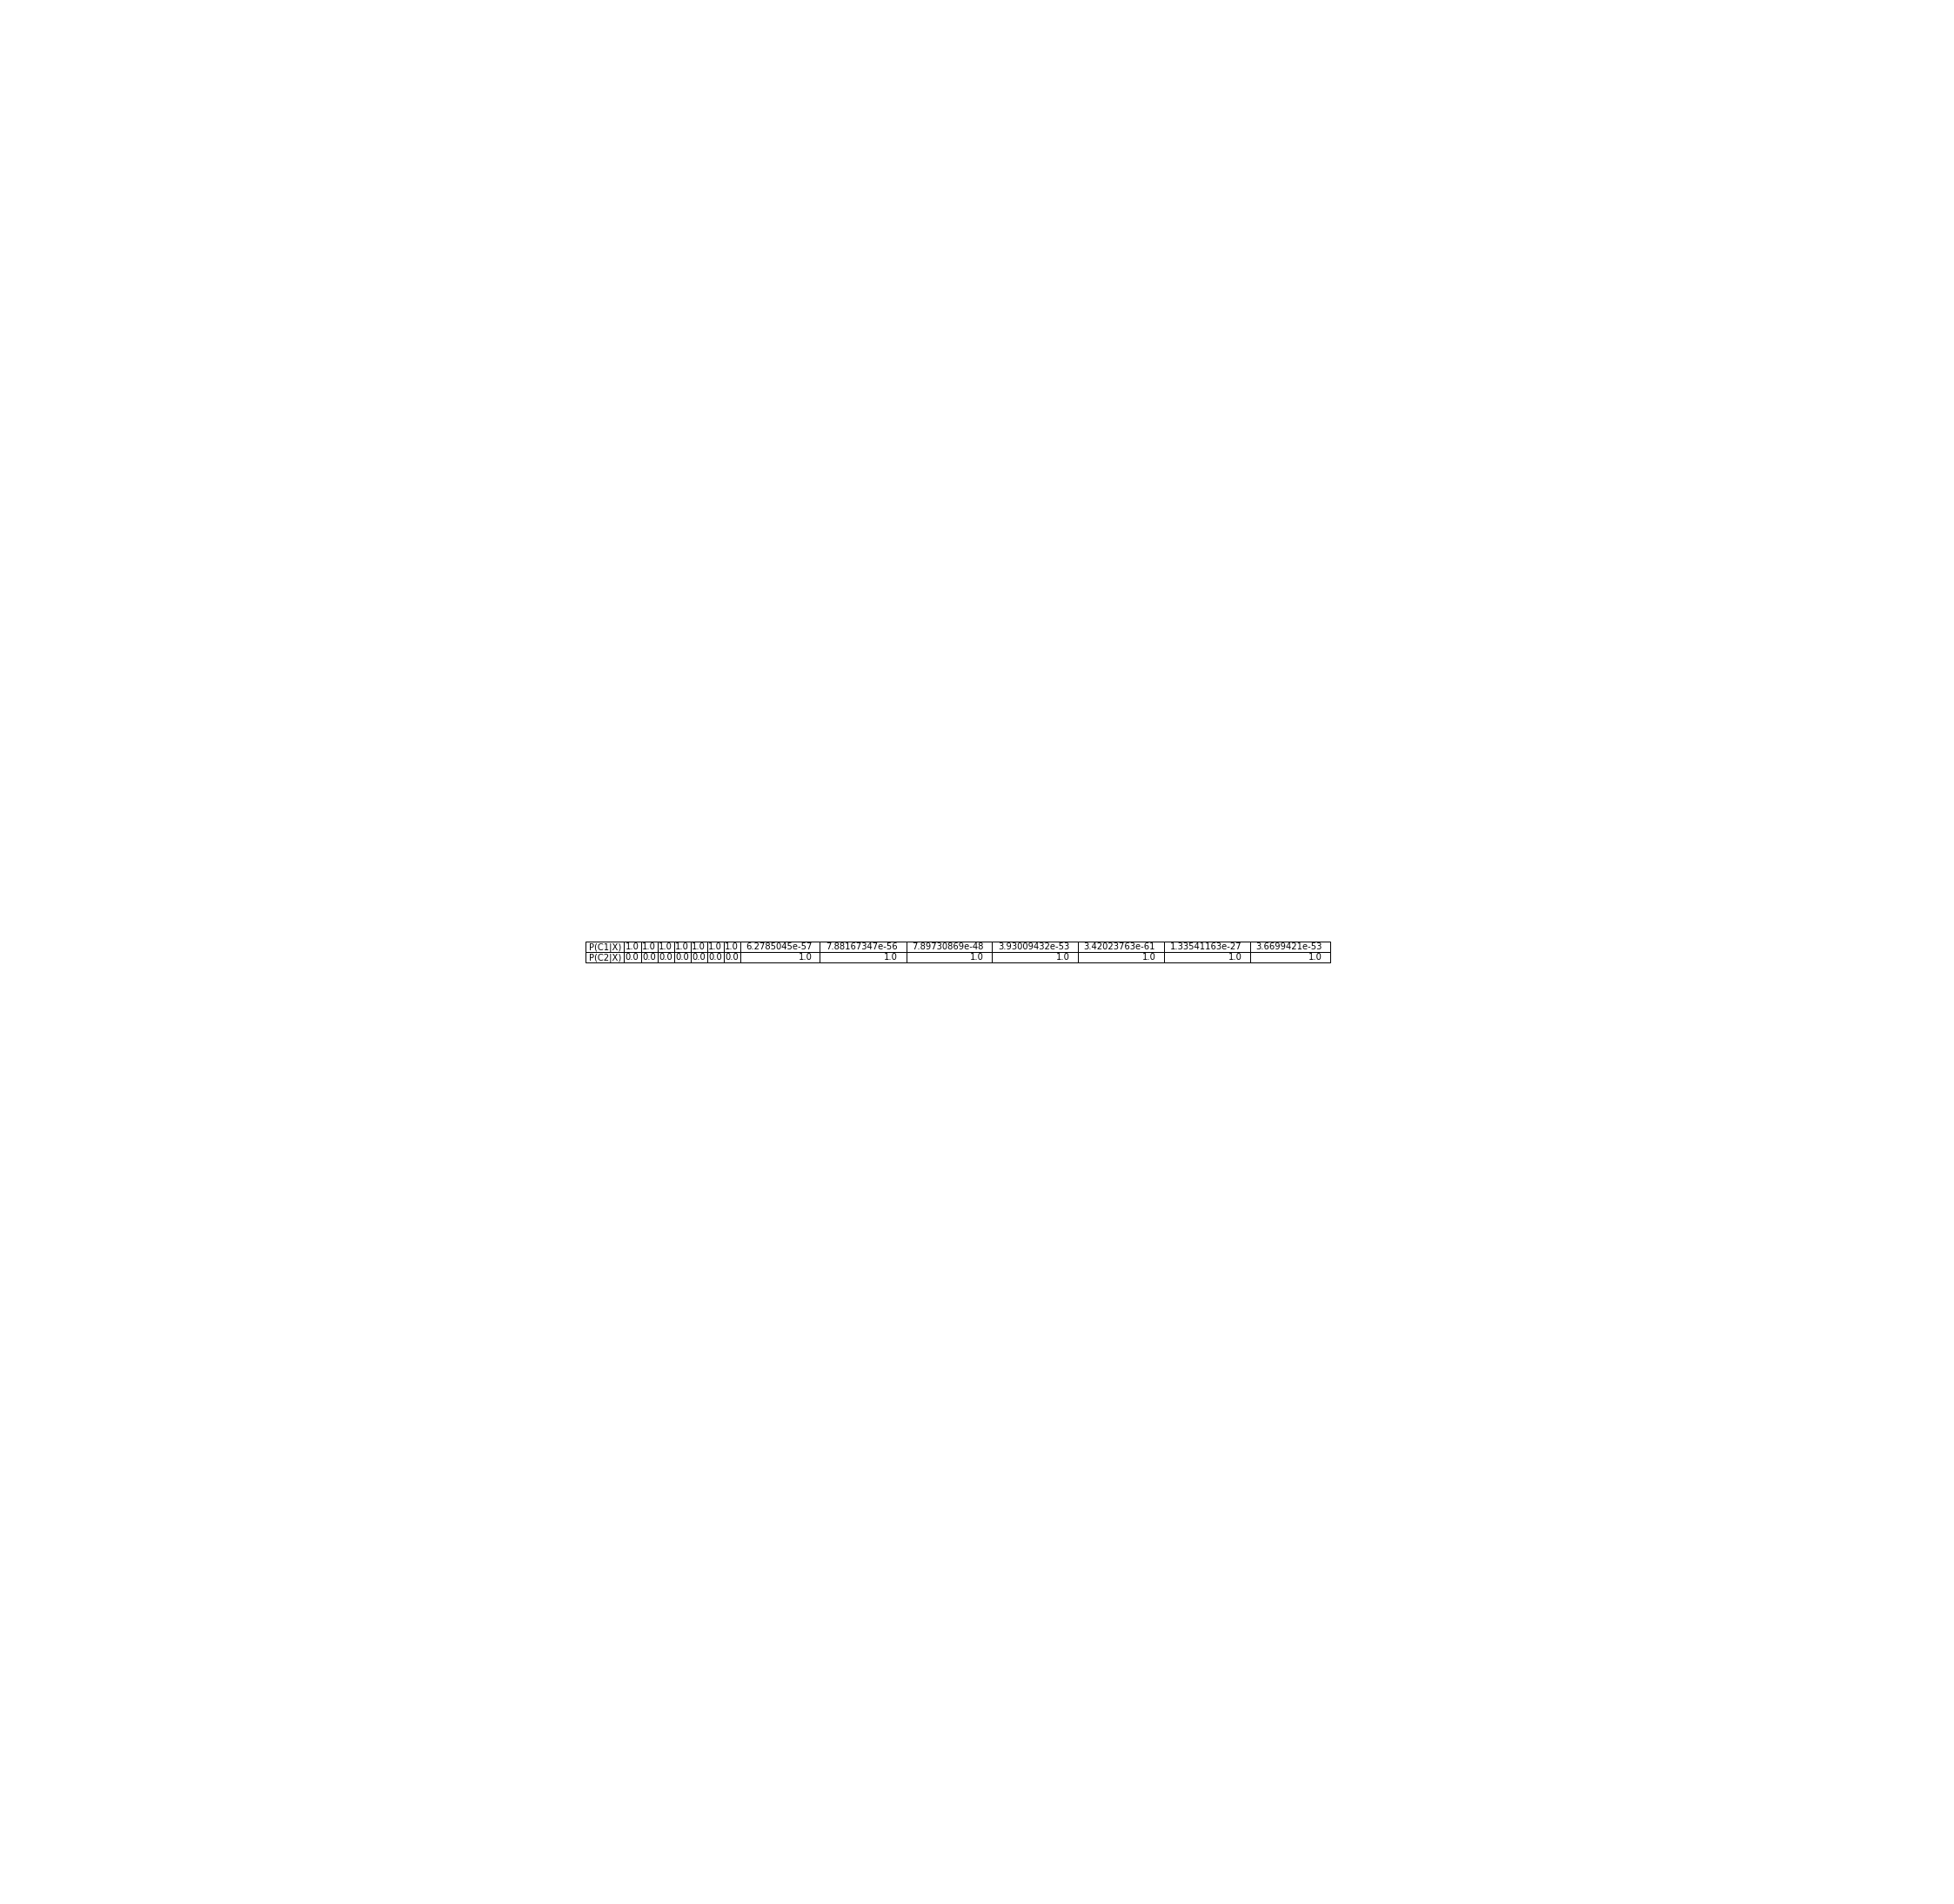

In [ ]:
fig, axs =plt.subplots(1,1, figsize = (40,40))
clust_data = prob.T
rowlabel=("P(C1|X)", "P(C2|X)")
axs.axis('off')
axs.axis('tight')
the_table = axs.table(cellText=clust_data ,rowLabels = rowlabel,loc='center', )
the_table.auto_set_column_width(col=list(range(clust_data.shape[1])))
plt.savefig('prob.png')
plt.show()


In [ ]:
class Config():
    def __init__(self):
        self.state_dim = 4
        self.conv_layer = 8
        self.hidden_dim = 32
        self.action_dim = 2
        self.layer_num = 2
        self.gamma = 0.995

class DQN(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.gamma = config.gamma
        self.action_dim = config.action_dim
        self.evaluate_net = self.build_model(config)
        self.target_net = self.build_model(config)
        self.batch_size = 50
        self.device = torch.device('cuda')
        
    def build_model(self,config):
        model = nn.Sequential(nn.Linear(config.state_dim,32),nn.ReLU(),nn.Linear(32,32),nn.ReLU(),nn.Linear(32,config.action_dim))
        return model
    def learn(self,state_m, action_m, _state_m, reward_m):
        state_m = torch.tensor(state_m).type('torch.FloatTensor').to(self.device)
        action_m = torch.tensor(action_m).type('torch.LongTensor').to(self.device)
        reward_m = torch.tensor(reward_m).type('torch.FloatTensor').to(self.device)
        _state_m = torch.tensor(_state_m).type('torch.FloatTensor').to(self.device)
        
        current_value = self.evaluate_net(state_m)
        future_value = self.target_net(_state_m)
        max_action = np.argmax(future_value.detach().cpu().numpy(),axis = 1)
        max_action = torch.tensor(max_action).type('torch.LongTensor').to(self.device)
        
        
        difference_ = reward_m + 0.995 * future_value.gather(1,max_action.view(-1,1)) - current_value.gather(1,action_m.view(-1,1))

        return torch.sum(difference_ ** 2)/difference_.size()[0]
      
class PolicyGradient(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.state_dim = config.state_dim
        self.action_dim = config.action_dim
        
        self.layer1 = nn.Linear(self.state_dim,32)
        self.layer2 = nn.Linear(32, self.action_dim)
        self.softmax = nn.Softmax(dim = 1)
    def forward(self, input_data):
        h1 = self.layer1(input_data)
        h2 = self.layer2(h1)
        return self.softmax(h2)
      
class Actor(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.state_dim = config.state_dim
        self.hidden_dim = config.hidden_dim
        self.layer_num = config.layer_num
        self.action_dim = config.action_dim
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)
        
        self.layers = []
        self.layers.append(nn.Linear(self.state_dim, self.hidden_dim))
        self.layers.append(self.relu)

        for i in range(self.layer_num):
            self.layers.append(nn.Linear(self.hidden_dim,self.hidden_dim))
            self.layers.append(self.relu)

        self.layers.append(nn.Linear(self.hidden_dim,self.action_dim))
        self.layers.append(self.softmax)
        self.module = nn.Sequential(*self.layers)

    def forward(self,state):
        action_prob = self.module(state)
        return action_prob

class Critic(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.state_dim = config.state_dim
        self.hidden_dim = config.hidden_dim
        self.layer_num = config.layer_num
        self.expacted_advantage = 1
        self.gamma = config.gamma
        self.relu = nn.ReLU()

        self.layers = []
        self.layers.append(nn.Linear(self.state_dim,self.hidden_dim))
        self.layers.append(self.relu)
        for i in range(self.layer_num):
            self.layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.layers.append(self.relu)
        self.layers.append(nn.Linear(self.hidden_dim, self.expacted_advantage))
        self.module = nn.Sequential(*self.layers)

    def forward(self, state):
        advantage = self.module(state)
        return advantage

NameError: ignored

##Actor Critic

In [ ]:
config = Config()
device = torch.device('cuda')
actor = Actor(config)
critic = Critic(config)
actor = actor.to(device)
critic = critic.to(device)
a_optim = optims.Adam(actor.module.parameters(),lr = 1e-4, weight_decay  = 1e-3)
c_optim = optims.Adam(critic.module.parameters(),lr = 1e-3, weight_decay = 1e-3)

NameError: ignored

In [ ]:
def discount_rewards(r):
    discounted_r=np.zeros_like(r)
    running_add=0
    for t in reversed(range(len(r))):
        running_add=running_add*0.9+r[t]
        discounted_r[t]=running_add
    return discounted_r


def loss_function(state,action,state_,reward):
    current_advantage = critic(state)
    future_advantage = critic(state_)
    
    action_prob = actor(state)
    
    td_error = torch.tensor([reward]).type('torch.FloatTensor').to(device) - current_advantage[0]
    action_error = -torch.log(action_prob[0,action]) * td_error
    
    return (td_error ** 2), action_error
    
def loss_function2(state_m,action_m,_state_m,reward_m,done_m):
    #reward_m = discount_rewards(reward_m)
    reward_m = torch.tensor(reward_m).type('torch.FloatTensor').to(device)
    reward_m = reward_m.view(-1,1)
    
    state_m = torch.cat(state_m,dim = 0).to(device)
    _state_m = torch.cat(_state_m,dim = 0).to(device)
    done_m = torch.tensor(done_m).type('torch.FloatTensor').to(device)
    
    current_advantage = critic(state_m)
    future_advantage = critic(_state_m)
    
    action_prob = actor(state_m)
    action_m = torch.tensor(action_m).type('torch.LongTensor').to(device)
    td_error = reward_m + done_m * 0.9 *torch.tensor(future_advantage.detach().cpu().numpy()).to(device) - current_advantage
    action_error = -torch.log(action_prob.gather(1,action_m.view(-1,1))+1e-5) * td_error
    msq_td_error = torch.mean(td_error **2)
    action_error = torch.mean(action_error)
    return msq_td_error + action_error


Actor critic不好收斂，其中使用on_policy搭配discount的reward會比用off_policy更好，off_policy的actor cirtic訓練會有問題

In [ ]:
env = gym.make('CartPole-v1')
for i in range(10000):
    total_reward = 0
    done = False
    observation = env.reset()
    observation = torch.tensor([observation]).type('torch.FloatTensor').to(device)
    count = 0 
    output = True
    state_m = []
    _state_m = []
    action_m = []
    reward_m = []
    done_m = []
    while not done:
        action_prob = actor(observation)
        action = np.random.choice(np.arange(2), p = action_prob.detach().cpu().numpy()[0])
        observation_, reward, done,info = env.step(action)
        observation_ = torch.tensor([observation_]).type('torch.FloatTensor').to(device)
        if done:
               reward = -20
                
        state_m.append(observation)
        _state_m.append(observation_)
        reward_m.append(reward)
        action_m.append(action)
        
        if done:
            done_m.append(0)
        else:
            done_m.append(1)
        total_reward += reward
        
        observation = observation_
    loss = loss_function2(state_m,action_m,_state_m, reward_m,done_m)
    
    a_optim.zero_grad()
    c_optim.zero_grad()
    
    
    loss.backward(retain_graph = True)
    a_optim.step()
    c_optim.step()
    if i %10 == 0:
        print("reward = ",total_reward)

##DQN

In [ ]:
config = Config()
device = torch.device('cuda')
dqn = DQN(config)
dqn = dqn.to(device)
optim = optims.SGD(dqn.evaluate_net.parameters(),lr = 5e-3)

In [ ]:
env = gym.make('CartPole-v0')
epislon = 0.5
delta = 0.00004
count = 0
state_m = np.zeros((500,4))
_state_m = np.zeros((500,4))
action_m = np.zeros((500,1),dtype = 'int32')
reward_m = np.zeros((500,1))
batch_size = 200

for i in range(10000):
    total_reward = 0
    done = False
    observation = env.reset()
    observation = torch.tensor([observation]).type('torch.FloatTensor').to(device)
    output = True
    loss = None
    while not done:
        action_value = dqn.evaluate_net(observation)
        action = np.argmax(action_value.detach().cpu().numpy()[0])
        if np.random.uniform()>epislon:
            action = np.random.choice(2)
          
        
        observation_, reward, done,info = env.step(action)
        
        observation_ = torch.tensor([observation_]).type('torch.FloatTensor').to(device)
        total_reward += reward     
        if done:
            reward = -20
        
        state_m[count % 500] = observation.detach().cpu().numpy()
        _state_m[count % 500] = observation_.detach().cpu().numpy()
        action_m[count % 500] = action
        reward_m[count % 500] = reward
        
        if count >batch_size and count % 10 == 0:
            batch_index = np.random.choice(state_m.shape[0],batch_size)
            loss = dqn.learn(state_m[batch_index], action_m[batch_index], _state_m[batch_index], reward_m[batch_index])
            optim.zero_grad()
            loss.backward()
            optim.step()
        observation = observation_
        count += 1
    if i %2 == 0:
        print("reward = ",total_reward)
        dqn.target_net.load_state_dict(dqn.evaluate_net.state_dict())
    epislon += delta

In [ ]:
env = gym.make('CartPole-v0')
print(env.action_space)

In [ ]:
number = 8

In [ ]:
print(11/4 - ((-3/4)*np.log2(3/8) + 0.5))

1.188721875540867


##DQN_Priorited_Replay

In [ ]:
class SumTree():
    def __init__(self,capacity,state_dim):
        self.capacity = capacity
        self.data_index = 0
        self.priority = np.zeros((2 * self.capacity - 1, 1))
        self.data = np.zeros((self.capacity,2*state_dim + 2))
    def add_leaf(self, transition, priority):
        change = priority - self.priority[self.data_index + self.capacity - 1] 
        self.priority[self.data_index + self.capacity - 1] = priority
        tmp = (self.data_index + self.capacity - 2)//2
        while tmp >=0:

            self.priority[tmp] += change
            tmp = (tmp-1)//2
        
        self.data[self.data_index] = transition
        self.data_index += 1
        
        if self.data_index >= self.capacity:
            self.data_index %= self.capacity

    def get_leaf(self, priority):
        
        root_index = 0

        while True:
            leaf_index = 2 * root_index + 1
            right_index = leaf_index + 1
            if leaf_index >= (2 * self.capacity - 1):
                break

            else:
                if priority <= self.priority[leaf_index]:
                    root_index = leaf_index
                else:
                    root_index = right_index
                    priority -= self.priority[leaf_index]
        return root_index, self.priority[root_index], self.data[root_index - self.capacity+1]
    
    def update_leaf(self, priority_index, priority):
        change = priority - self.priority[priority_index]
        self.priority[priority_index] = priority
        priority_index = (priority_index - 1)//2

        while priority_index >= 0:
            self.priority[priority_index] += change
            priority_index = (priority_index-1)//2

    def total_priority(self):
        return self.priority[0]

In [ ]:
class DQN_PR():
    def __init__(self,config):
        super().__init__()
        self.gamma = config.gamma
        self.state_dim = config.state_dim
        self.action_dim = config.action_dim
        self.batch_size = 50
        self.device = torch.device('cuda')
        self.evaluate_net = self.build_model(config).to(self.device)
        self.target_net = self.build_model(config).to(self.device)
        self.capacity = 500
        self.max_abs_error = 20
        self.sumtree = SumTree(self.capacity, config.state_dim)
        self.beta = 0.4
        self.alpha = 0.6
        self.epsilon = 1e-7
    def build_model(self,config):
        model = nn.Sequential(nn.Linear(config.state_dim,32),nn.ReLU(),nn.Linear(32,32),nn.ReLU(),nn.Linear(32,config.action_dim))
        return model
    def store_transition(self,state, action, state_, reward):
        transition = np.hstack((state.reshape(1,-1),np.asarray(action).reshape(1,1),state_.reshape(1,-1),np.asarray(reward).reshape(1,1)))
        priority = np.abs(reward)
        self.sumtree.add_leaf(transition, priority)
        
    def learn(self, batch_size = 20):
        batch_transition = np.zeros((batch_size, 2 * self.state_dim + 2))
        batch_priority_index = np.zeros((batch_size,)).astype('int32')
        batch_ISWeight = np.zeros((batch_size,1))
        
        segment_size = self.sumtree.total_priority()/batch_size
        
        start_ = 0
        
        min_priority = np.min(self.sumtree.priority[-self.capacity:])
        total_p = self.sumtree.total_priority()
        for batch in range(batch_size):
            select_priority = np.random.uniform(start_, start_+segment_size)
            start_ = start_ + segment_size
            priority_index, priority, transition = self.sumtree.get_leaf(select_priority)

            batch_transition[batch] = transition
            batch_priority_index[batch] = priority_index
            batch_ISWeight[batch] = np.power(priority/total_p, -self.beta)
            
            
        batch_state = batch_transition[:, :self.state_dim]
        batch_action = batch_transition[:, self.state_dim:self.state_dim + 1]
        batch_state_ = batch_transition[:, self.state_dim + 1:self.state_dim + 1 + self.state_dim]
        batch_reward = batch_transition[:, self.state_dim + 1 + self.state_dim:]

        batch_state = torch.tensor(batch_state).type('torch.FloatTensor').to(self.device)
        batch_action = torch.tensor(batch_action).type('torch.LongTensor').to(self.device)
        batch_state_ = torch.tensor(batch_state_).type('torch.FloatTensor').to(self.device)
        batch_reward = torch.tensor(batch_reward).type('torch.FloatTensor').to(self.device)
        batch_ISWeight = torch.tensor(batch_ISWeight).type('torch.FloatTensor').to(self.device)

        current_value = self.evaluate_net(batch_state)
        future_value = self.target_net(batch_state_)
        max_action = np.argmax(future_value.detach().cpu().numpy(),axis = 1)
        max_action = torch.tensor(max_action).type('torch.LongTensor').to(self.device)

        td_error = batch_reward + future_value.gather(1,max_action.view(-1, 1)) - current_value.gather(1, batch_action.view(-1, 1))
        
        update_priority = np.abs(td_error.detach().cpu().numpy()) + self.epsilon
        update_priority = np.minimum(self.max_abs_error, update_priority)     
        update_priority = np.power(update_priority, self.alpha)
        
        for i in range(batch_size):
            self.sumtree.update_leaf(batch_priority_index[i], update_priority[i])
            
        loss = torch.mean(batch_ISWeight * (td_error ** 2))
        return loss

In [ ]:
config = Config()
dqn_pr = DQN_PR(config)
optim = optims.RMSprop(dqn_pr.evaluate_net.parameters(),lr=0.00025,eps=0.01)
device = torch.device('cuda')

In [ ]:
env = gym.make('CartPole-v1')
epislon = 0.1
delta = 0.0004
count = 0
state_m = np.zeros((500,4))
_state_m = np.zeros((500,4))
action_m = np.zeros((500,1),dtype = 'int32')
reward_m = np.zeros((500,1))
batch_size = 200

for i in range(10000):
    total_reward = 0
    done = False
    observation = env.reset()
    observation = torch.tensor([observation]).type('torch.FloatTensor').to(device)
    output = True
    loss = None
    while not done:
        action_value = dqn_pr.evaluate_net(observation)
        action = np.argmax(action_value.detach().cpu().numpy()[0])
        if np.random.uniform()>epislon:
            action = np.random.choice(2)
          
        
        observation_, reward, done,info = env.step(action)
        observation_ = torch.tensor([observation_]).type('torch.FloatTensor').to(device)    
        
        if done:
            reward = -20
        dqn_pr.store_transition(observation.detach().cpu().numpy(), action, observation_.detach().cpu().numpy(), reward)
        if count >batch_size and count % 10 == 0:
            loss = dqn_pr.learn()
            optim.zero_grad()
            loss.backward()
            optim.step()
        total_reward += 1
        observation = observation_
        count += 1
    if i %2 == 0:
        print("reward = ",total_reward)
        dqn_pr.target_net.load_state_dict(dqn_pr.evaluate_net.state_dict())
    epislon += delta

reward =  42
reward =  17
reward =  10
reward =  29
reward =  20
reward =  16
reward =  63
reward =  14
reward =  12
reward =  15
reward =  17
reward =  11
reward =  17
reward =  27
reward =  17
reward =  12
reward =  17
reward =  28
reward =  30
reward =  12
reward =  19
reward =  14
reward =  16
reward =  38
reward =  29
reward =  51
reward =  14
reward =  58
reward =  15
reward =  31
reward =  23
reward =  21
reward =  68
reward =  20
reward =  14
reward =  16
reward =  18
reward =  13
reward =  13
reward =  10
reward =  17
reward =  18
reward =  12
reward =  23
reward =  13
reward =  21
reward =  15
reward =  29
reward =  24
reward =  21
reward =  31
reward =  11
reward =  14
reward =  30
reward =  32
reward =  18
reward =  14
reward =  15
reward =  16
reward =  27
reward =  17
reward =  16
reward =  30
reward =  20
reward =  19
reward =  18
reward =  33
reward =  15
reward =  20
reward =  12
reward =  14
reward =  62
reward =  19
reward =  12
reward =  12
reward =  14
reward =  15

KeyboardInterrupt: ignored

注意當發現reward出現問題(隨著訓練往下降)，除了是

In [ ]:
config = Config()
pg = PolicyGradient(config)
device = torch.device('cuda')
pg = pg.to(device)

In [ ]:
env = gym.make('CartPole-v1')
epislon = 0.5
delta = 0.00004
count = 0
batch_size = 200

for i in range(10000):
    total_reward = 0
    done = False
    observation = env.reset()
    observation = torch.tensor([observation]).type('torch.FloatTensor').to(device)
    output = True
    loss = None
    while not done:
        action_value = pg(observation)
        action_value = action_value.detach().cpu().numpy()
        action = np.random.choice(len(action_value),p = action_value)
         
        observation_, reward, done,info = env.step(action)
        observation_ = torch.tensor([observation_]).type('torch.FloatTensor').to(device)    
        
        if done:
            reward = -20
        dqn_pr.store_transition(observation.detach().cpu().numpy(), action, observation_.detach().cpu().numpy(), reward)
        if count >batch_size and count % 10 == 0:
            loss = dqn_pr.learn()
            optim.zero_grad()
            loss.backward()
            optim.step()
        total_reward += 1
        observation = observation_
        count += 1
    if i %2 == 0:
        print("reward = ",total_reward)
        dqn_pr.target_net.load_state_dict(dqn_pr.evaluate_net.state_dict())
    epislon += delta

In [ ]:
class SumTree():
    def __init__(self,capacity,state_dim):
        self.capacity = capacity
        self.data_index = 0
        self.priority = np.zeros((2 * self.capacity - 1, 1))
        self.data = np.zeros((self.capacity,2*state_dim + 3))
    def add_leaf(self, transition, priority):
        change = priority - self.priority[self.data_index + self.capacity - 1] 
        self.priority[self.data_index + self.capacity - 1] = priority
        tmp = (self.data_index + self.capacity - 2)//2
        while tmp >=0:

            self.priority[tmp] += change
            tmp = (tmp-1)//2
        
        self.data[self.data_index] = transition
        self.data_index += 1
        
        if self.data_index >= self.capacity:
            self.data_index %= self.capacity

    def get_leaf(self, priority):
        
        root_index = 0

        while True:
            leaf_index = 2 * root_index + 1
            right_index = leaf_index + 1
            if leaf_index >= (2 * self.capacity - 1):
                break

            else:
                if priority <= self.priority[leaf_index]:
                    root_index = leaf_index
                else:
                    root_index = right_index
                    priority -= self.priority[leaf_index]
        return root_index, self.priority[root_index], self.data[root_index - self.capacity+1]
    
    def update_leaf(self, priority_index, priority):
        change = priority - self.priority[priority_index]
        self.priority[priority_index] = priority
        priority_index = (priority_index - 1)//2

        while priority_index >= 0:
            self.priority[priority_index] += change
            priority_index = (priority_index-1)//2

    def total_priority(self):
        return self.priority[0]
class DQN_PR():
    def __init__(self,config):
        super().__init__()
        self.gamma = config.gamma
        self.state_dim = config.state_dim
        self.action_dim = config.action_dim
        self.batch_size = 50
        self.device = torch.device('cuda')
        self.evaluate_net = self.build_model(config).to(self.device)
        self.target_net = self.build_model(config).to(self.device)
        self.capacity = 500
        self.max_abs_error = 20
        self.sumtree = SumTree(self.capacity, config.state_dim)
        self.beta = 0.4
        self.alpha = 0.6
        self.epsilon = 1e-7
    def build_model(self,config):
        model = nn.Sequential(nn.Linear(config.state_dim,32),nn.ReLU(),nn.Linear(32,32),nn.ReLU(),nn.Linear(32,config.action_dim))
        return model
    def store_transition(self,state, action, state_, reward, done):
        transition = np.hstack((state.reshape(1,-1),np.asarray(action).reshape(1,1),state_.reshape(1,-1),np.asarray(reward).reshape(1,1), np.asarray(done).reshape(1,1)))
                               
        priority = np.abs(reward)
        self.sumtree.add_leaf(transition, priority)
        
    def learn(self, batch_size = 20):
        batch_transition = np.zeros((batch_size, 2 * self.state_dim + 3))
        batch_priority_index = np.zeros((batch_size,)).astype('int32')
        batch_ISWeight = np.zeros((batch_size,1))
        
        segment_size = self.sumtree.total_priority()/batch_size
        
        start_ = 0
        
        min_priority = np.min(self.sumtree.priority[-self.capacity:])
        total_p = self.sumtree.total_priority()
        for batch in range(batch_size):
            select_priority = np.random.uniform(start_, start_+segment_size)
            start_ = start_ + segment_size
            priority_index, priority, transition = self.sumtree.get_leaf(select_priority)

            batch_transition[batch] = transition
            batch_priority_index[batch] = priority_index
            batch_ISWeight[batch] = np.power(priority/total_p, -self.beta)
            
            
        batch_state = batch_transition[:, :self.state_dim]
        batch_action = batch_transition[:, self.state_dim:self.state_dim + 1]
        batch_state_ = batch_transition[:, self.state_dim + 1:self.state_dim + 1 + self.state_dim]
        batch_reward = batch_transition[:, self.state_dim + 1 + self.state_dim: 2 * self.state_dim + 2]
        batch_done = batch_transition[:, 2 * self.state_dim + 2:]
        
        batch_state = torch.tensor(batch_state).type('torch.FloatTensor').to(self.device)
        batch_action = torch.tensor(batch_action).type('torch.LongTensor').to(self.device)
        batch_state_ = torch.tensor(batch_state_).type('torch.FloatTensor').to(self.device)
        batch_reward = torch.tensor(batch_reward).type('torch.FloatTensor').to(self.device)
        batch_done = torch.tensor(batch_done).type(torch.FloatTensor).to(self.device)
        batch_ISWeight = torch.tensor(batch_ISWeight).type('torch.FloatTensor').to(self.device)

        current_value = self.evaluate_net(batch_state)
        future_value = self.target_net(batch_state_)
        max_action = np.argmax(future_value.detach().cpu().numpy(),axis = 1)
        max_action = torch.tensor(max_action).type('torch.LongTensor').to(self.device)

        td_error = batch_reward + future_value.gather(1,max_action.view(-1, 1)) * batch_done - current_value.gather(1, batch_action.view(-1, 1))
        
        update_priority = np.abs(td_error.detach().cpu().numpy()) + self.epsilon
        update_priority = np.minimum(self.max_abs_error, update_priority)     
        update_priority = np.power(update_priority, self.alpha)
        
        for i in range(batch_size):
            self.sumtree.update_leaf(batch_priority_index[i], update_priority[i])
            
        loss = torch.mean(batch_ISWeight * (td_error ** 2))
        return loss

In [ ]:
config = Config()
dqn_pr = DQN_PR(config)
optim = optims.RMSprop(dqn_pr.evaluate_net.parameters(),lr=0.00025,eps=0.01)
device = torch.device('cuda')

In [ ]:
env = gym.make('CartPole-v1')
epislon = 0.1
delta = 0.0004
count = 0
state_m = np.zeros((500,4))
_state_m = np.zeros((500,4))
action_m = np.zeros((500,1),dtype = 'int32')
reward_m = np.zeros((500,1))
batch_size = 200

for i in range(2000):
    total_reward = 0
    done = False
    observation = env.reset()
    observation = torch.tensor([observation]).type('torch.FloatTensor').to(device)
    output = True
    loss = None
    while not done:
        action_value = dqn_pr.evaluate_net(observation)
        action = np.argmax(action_value.detach().cpu().numpy()[0])
        if np.random.uniform()>epislon:
            action = np.random.choice(2)
          
        
        observation_, reward, done,info = env.step(action)
        observation_ = torch.tensor([observation_]).type('torch.FloatTensor').to(device)    
        
        if done:
            reward = -20
            dqn_pr.store_transition(observation.detach().cpu().numpy(), action, observation_.detach().cpu().numpy(), reward, 0.0)
        else:
            dqn_pr.store_transition(observation.detach().cpu().numpy(), action, observation_.detach().cpu().numpy(), reward, 1.0)
        if count >batch_size and count % 10 == 0:
            loss = dqn_pr.learn()
            optim.zero_grad()
            loss.backward()
            optim.step()
        total_reward += 1
        observation = observation_
        count += 1
    if i %2 == 0:
        print("reward = ",total_reward)
        dqn_pr.target_net.load_state_dict(dqn_pr.evaluate_net.state_dict())
    epislon += delta

reward =  23
reward =  24
reward =  21
reward =  34
reward =  16
reward =  17
reward =  13
reward =  11
reward =  32
reward =  36
reward =  11
reward =  15
reward =  13
reward =  10
reward =  27
reward =  19
reward =  10
reward =  26
reward =  13
reward =  9
reward =  13
reward =  16
reward =  41
reward =  13
reward =  10
reward =  20
reward =  40
reward =  18
reward =  15
reward =  25
reward =  14
reward =  47
reward =  16
reward =  33
reward =  31
reward =  12
reward =  15
reward =  35
reward =  38
reward =  13
reward =  21
reward =  19
reward =  17
reward =  39
reward =  17
reward =  12
reward =  14
reward =  11
reward =  18
reward =  25
reward =  17
reward =  28
reward =  34
reward =  13
reward =  19
reward =  21
reward =  36
reward =  9
reward =  10
reward =  17
reward =  14
reward =  21
reward =  10
reward =  15
reward =  11
reward =  13
reward =  66
reward =  31
reward =  39
reward =  11
reward =  30
reward =  15
reward =  13
reward =  40
reward =  21
reward =  14
reward =  41
r

KeyboardInterrupt: ignored